In [1]:
# libraries

import zipfile, re, logging
from io import BytesIO
import re
import os
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples


In [2]:
# Script to extract all the nested zip files

with zipfile.ZipFile("Data.zip", "r") as zfile:
    for name in zfile.namelist():
        if re.search(r'\.zip$', name) is not None:
            zfiledata = BytesIO(zfile.read(name))
            #zfile.extractall()
            with zipfile.ZipFile(zfiledata) as zfile2:
                zfile2.extractall("./Data/")   
                
# extracting some information from xml file

listText = []
listHeadlines = []
listFileName = []
listItemID = []

listTopics = []
listTemp = []
listPublishedDate = []
ListBipTopics = []

for filename in os.listdir('./Data/'):
    if filename.endswith('.xml'):
        with open(os.path.join('./Data/', filename)) as f:
            strings = f.read() 
            f.close()
            matchesText = re.findall(r"(?<=<text>).*?(?=</text>)", strings, flags=re.DOTALL)
            matchesHeadlines = re.findall(r"(?<=<headline>).*?(?=</headline>)", strings, flags=re.DOTALL)
            matchesItemID = re.findall(r"<newsitem(?:\D+=\"\S*\")*\s+itemid=\"(\d*)\"", strings, flags=re.DOTALL)
            for text in matchesText:
                listText.append(text)
            for headline in matchesHeadlines:
                listHeadlines.append(headline)
            listFileName.append(filename)
            for itemid in matchesItemID:
                listItemID.append(itemid)    
# removing some tags/characetrs from text

listText = [txt.replace('<p>', ' ').replace('</p>', ' ').replace('\n', ' ') for txt in listText]

for filename in os.listdir('./Data/'):
    if filename.endswith('.xml'):
        with open(os.path.join('./Data/', filename)) as f:
            strings = f.read() 
            soup = BeautifulSoup(strings)
            listset=soup("codes","bip:topics:1.0")
            for top in listset:
                listTemp += [a['code'] for a in top.findAll('code',{'code':True})]
            listTopics.append(listTemp)
            listTemp =[]    
            
            inputTag = soup(attrs={"element" : "dc.date.published"})
            output = inputTag[0]['value']
            listPublishedDate.append(output)

for sublist in listTopics:
    s = [str(i) for i in sublist]   
    res = ",".join(s) 
    ListBipTopics.append(res)

In [4]:
def extractDataframe(HeadlinesList, TextList, BitopicsList, PublishedDateList, ItemIDList, FileNamesList, columnsList):
    df = pd.DataFrame(list(zip(HeadlinesList,TextList,BitopicsList,PublishedDateList,ItemIDList,FileNamesList)), columns=columnsList)
    return df

def preprocessedData(dataframe, textColumn):
    dataframe[textColumn] = dataframe[textColumn].map(lambda x: re.sub(r'\W+', ' ', x))   #removing special character
    dataframe[textColumn] = dataframe[textColumn].map(lambda x: re.sub(r'\d+', '', x))    # removing all the digits
    dataframe[textColumn] = dataframe[textColumn].map(lambda x: x.lower())                # converting into lower case

    # tokenize the words
    dataframe[textColumn] = dataframe[textColumn].map(lambda x: nltk.word_tokenize(x))

    # remove stop words
    stop = stopwords.words('english')
    dataframe[textColumn] = dataframe[textColumn].map(lambda x: [item for item in x if item not in stop])

    #lemmatization
    lemmatizer=WordNetLemmatizer()
    dataframe[textColumn] = dataframe[textColumn].map(lambda x: [lemmatizer.lemmatize(item) for item in x])

def featureExtraction(dataframe, textColumn, topicsColumn):
    countVect = CountVectorizer(tokenizer=lambda x: x, lowercase=False).fit_transform(dataframe[textColumn])
    tfidfTrans = TfidfTransformer()
    tfidfOfText = tfidfTrans.fit_transform(countVect)
    print("Features Shape",tfidfOfText.shape)
    dataframe[topicsColumn]=dataframe[topicsColumn].str.split(',').str[0]
    dataframe[topicsColumn] = dataframe[topicsColumn].astype('category')
    dataframe[topicsColumn] = dataframe[topicsColumn].cat.codes
    return tfidfOfText,dataframe[topicsColumn]

def preprocessing(dataframe, textColumn, topicsColumn):
    countVect = CountVectorizer(tokenizer=lambda x: x, lowercase=False).fit_transform(dataframe[textColumn])
    tfidfTrans = TfidfTransformer()
    tfidfOfText = tfidfTrans.fit_transform(countVect)
    return tfidfOfText,dataframe[topicsColumn]

def splitDataset(Feature, Target, testSize, randomState):
    X_train, X_test, y_train, y_test = train_test_split(Feature, Target, test_size=testSize, random_state=randomState)
    return X_train, X_test, y_train, y_test

def generateClassifier(features, labels, classifier,gamma='scale',kernel='linear',estimators=200):
    labels=labels.astype('int')
    X_train, X_test, y_train, y_test = splitDataset(features, labels, 0.3, 25)
    if(classifier == DecisionTreeClassifier):
        clf = classifier()
    elif(classifier == SVC):
        clf = classifier(gamma=gamma, kernel=kernel)
    elif(classifier == RandomForestClassifier):
        clf = classifier(n_estimators=estimators)
    elif(classifier == LinearRegression):
        clf = classifier()
    
    clf = clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    return predicted, y_test

def evaluateModel(y_test, predictedValues):
    accuracyScore = np.mean(predictedValues == y_test)
    return accuracyScore
# craeting DataFrame and Preprocessing the data    
columns = ['HeadLine','Text','Bi:Topics','Date Published','Itemid','XMLfileName']
df = extractDataframe(listHeadlines,listText,ListBipTopics,listPublishedDate,listItemID,listFileName,columns)
preprocessedData(df,'Text')


In [5]:
df

,HeadLine,Text,Bi:Topics,Date Published,Itemid,XMLfileName
0,Canadian Occidental mounts rival Wascana bid.,"[canadian, occidental, petroleum, ltd, emerged...",C181,1997-03-18,326914,326914newsML.xml
1,"Gruma, Maseca to receive syndicated loan - bank.","[bank, america, launch, three, year, million, ...",C173,1997-03-18,326915,326915newsML.xml
2,Too early to call Krupp bid hostile - Deutsche...,"[deutsche, bank, ag, management, board, member...","C18,C181,CCAT",1997-03-18,326916,326916newsML.xml
3,"FOCUS - Euro bourses fret over Wall St, electi...","[european, bourse, fell, tuesday, even, wall, ...","M11,M13,M132,M14,M142,MCAT",1997-03-18,326917,326917newsML.xml
4,"French stocks fall, Alcatel posts big gain.","[french, share, closed, lower, tuesday, second...","G152,M11",1997-03-18,326918,326918newsML.xml
5,"UK shares end lower, depressed by Dow and poli...","[london, ftse, index, ended, lower, thursday, ...","M11,MCAT",1997-03-18,326919,326919newsML.xml
6,FOCUS - Coffee drops after a spectacular rally.,"[world, coffee, market, tumble, spectacular, r...","M14,M141,MCAT",1997-03-18,326920,326920newsML.xml
7,BOMBAY LEADING STOCKS CLOSING PRICES - March 13.,"[today, close, previous, close, bombay, share,...","M11,MCAT",1997-03-13,368468,368468newsML.xml
8,"MQM joins Sindh cabinet in Pakistan, governor ...","[pakistani, ethnic, movement, blamed, past, tu...","GCAT,GPOL,GVIO",1997-03-13,368469,368469newsML.xml
9,Sri Lanka launches multiple attacks on rebel b...,"[sri, lankan, force, launched, air, naval, art...","GCAT,GVIO",1997-03-13,368470,368470newsML.xml


# 1. Clustering the documents

### Silhouitte score to find the value of k in k-means clustering algorithm

K-means cluster algorithm used to cluster the data. K-means algorithm groups similar data into one cluster, where we need to the the number of cluster k initially. Here I am using elbow method and silhouette coefficient to find the best value for k.

As shown in the Silhouette plot, for k = 9, the sum of Silhouette values are the maximum. Hence, I am keeping k=9 for this clustering. 

I tried DBSCAN, but it didnt work well, DBSCAN groups data into clusters, where some clusters are relatively large and some clusters are relatively small, which is not good for classfication(As some cluster dont have sufficient data to train the model). SO the main goal is here is not just to find the 'accurate' clustering algorithm, but the clustering algorithm, which creates cluster with sufficient data in each of them.

Note: we can also throw some clusters away, which very small amount of data, considering that data as outliers. But it is a loss of data, so i preferred clustering the data with sufficient amount of data. Hence, I am using k-means clustering, which gives the efficient results to fulfill these needs.

In k-means, we can define the number of cluster and especially for this data, each cluster has enough amount of data so that we can classify each cluster.

### Finding the value of k for K-Means Clustering algorithm

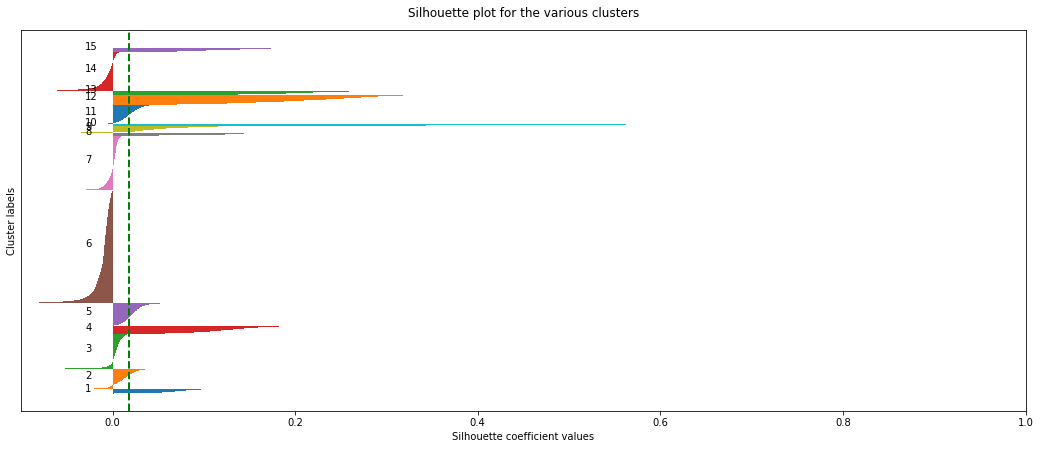

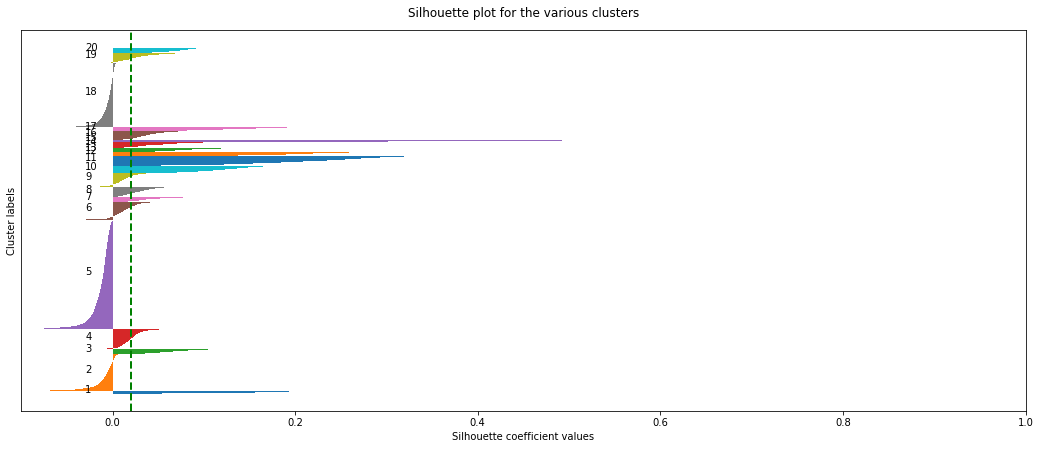

In [12]:
for i, k in enumerate([15,20]):
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(15, 5)
    
    # Kmeans algorithm
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(Features)
    centroids = kmeans.cluster_centers_

    silhouetteSamples = silhouette_samples(Features, labels)

    # Silhouette graph
    yLlower, yUpper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        vals = silhouetteSamples[labels == cluster]
        silhouetteSamples.sort()
        yUpper += len(vals)
        ax1.barh(range(yLlower, yUpper), vals, edgecolor='none', height=1)
        ax1.text(-0.03, (yLlower + yUpper) / 2, str(i + 1))
        yLlower += len(vals)

    ave = np.mean(silhouetteSamples)
    ax1.axvline(ave, linestyle='--', color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette coefficient values for different clusters');

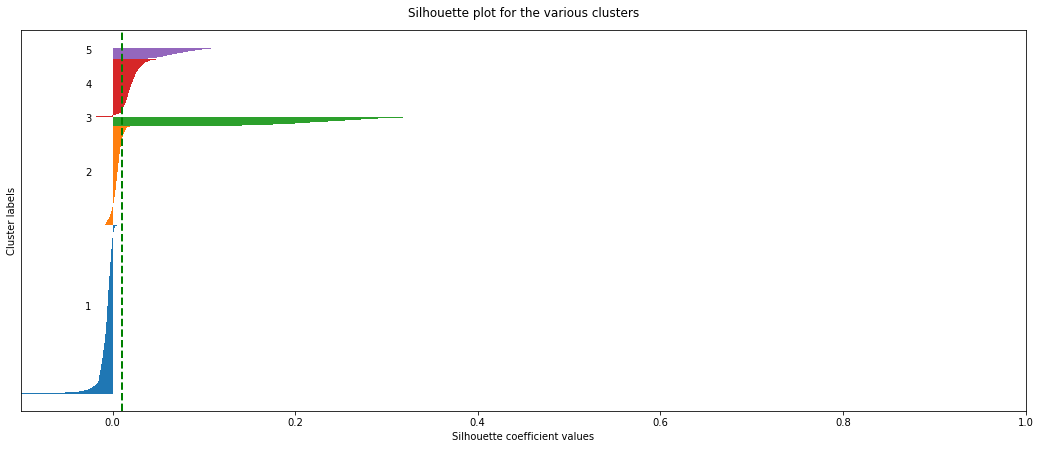

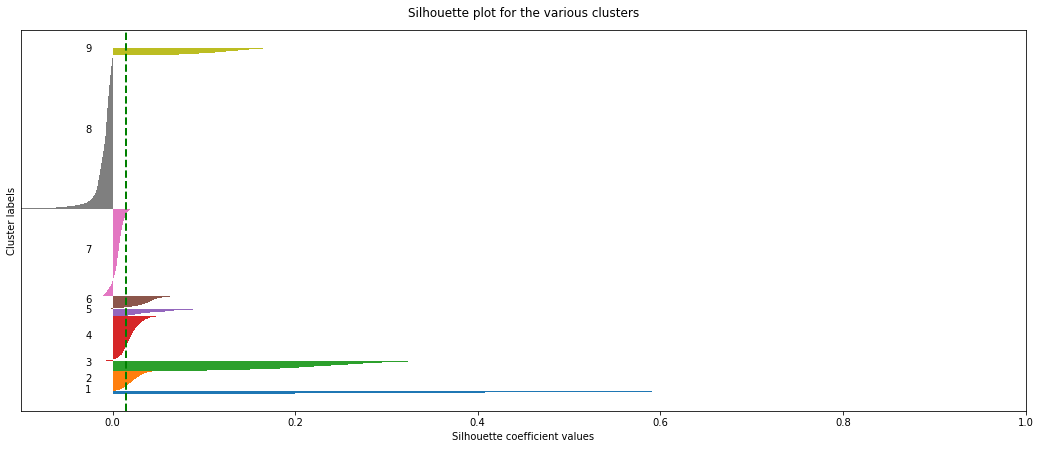

In [11]:
for i, k in enumerate([5,9]):
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(15, 5)
    
    # Kmeans algorithm
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(Features)
    centroids = kmeans.cluster_centers_

    silhouetteSamples = silhouette_samples(Features, labels)

    # Silhouette graph
    yLlower, yUpper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        vals = silhouetteSamples[labels == cluster]
        silhouetteSamples.sort()
        yUpper += len(vals)
        ax1.barh(range(yLlower, yUpper), vals, edgecolor='none', height=1)
        ax1.text(-0.03, (yLlower + yUpper) / 2, str(i + 1))
        yLlower += len(vals)

    ave = np.mean(silhouetteSamples)
    ax1.axvline(ave, linestyle='--', color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette coefficient values for different clusters');

### Function to cluster the document

In [37]:
# function to create clustres
def assignClusterID(dataframe, Features, Target, textColumn, topicColumns, clusteringAlgorithm, n_clusters):
    kmeans = clusteringAlgorithm(n_clusters=n_clusters).fit(Features)
    labels = kmeans.labels_
    array = np.array(labels)                        # attching all the labels for each row in dataframe
    dataframe['labels'] = array
    dfWithClustersID  = dataframe[[textColumn,topicColumns,'labels']]
    return dfWithClustersID
Features, Target= featureExtraction(df,'Text','Bi:Topics')

# calling cluster function
dfWithClustersID = assignClusterID(df, Features, Target, 'Text', 'Bi:Topics', KMeans, 9)

# storing cluster ID in csv file to make it resuable
import pandas as pd
dfWithClustersID.to_csv("./target.csv")
dfWithClustersID = pd.read_csv("./target.csv")

dfWithClustersID = dfWithClustersID.iloc[:,:3]
dfWithClustersID.head()

,Text,Bi:Topics,labels
0,"['canadian', 'occidental', 'petroleum', 'ltd',...",13,2
1,"['bank', 'america', 'launch', 'three', 'year',...",11,2
2,"['deutsche', 'bank', 'ag', 'management', 'boar...",12,4
3,"['european', 'bourse', 'fell', 'tuesday', 'eve...",64,5
4,"['french', 'share', 'closed', 'lower', 'tuesda...",46,5


### Applying SVM to each cluster to classify the documents

SVM is giving the best result so far. I tried multiple algorithms like linear regression, decision tree, random forest and even neural network. However, SVM works.

In [20]:
dict_of_companies = {k: v for k, v in dfWithClustersID.groupby('labels')}
smAccuracyList = []
for k in dict_of_companies:
    Features,Target = preprocessing(dict_of_companies[k],'Text', 'Bi:Topics')
    predicted, y_test = generateClassifier(Features, Target, SVC)
    accuracyScoreSVC = evaluateModel(y_test, predicted)
    smAccuracyList.append(accuracyScoreSVC)
    print("The Accuracy for SVM model is", accuracyScoreSVC)

Features Shape (1944, 5930)
The Accuracy for SVM model is 0.9212328767123288
Features Shape (2875, 12147)
The Accuracy for SVM model is 0.8551564310544612
Features Shape (21333, 63975)
The Accuracy for SVM model is 0.75546875
Features Shape (1074, 2544)
The Accuracy for SVM model is 1.0
Features Shape (12004, 53902)
The Accuracy for SVM model is 0.7387562465297057
Features Shape (6363, 21505)
The Accuracy for SVM model is 0.8124672603457308
Features Shape (1373, 5080)
The Accuracy for SVM model is 0.9757281553398058
Features Shape (818, 1475)
The Accuracy for SVM model is 1.0
Features Shape (591, 7196)
The Accuracy for SVM model is 0.9438202247191011


# 2. Evaluation of the clustering

I used Elblow method and Silhouette(which is implemented above) to evaluate the clustering. These evaluation matrix can be used to decide the efficient value of K and also to evaluate the performance k.

There is no perfect evaluation method for clustering, we can compare different values of K with each other and decide which works the best for us. thats excatly what these two evaluation methods do.

Elbow method gives an idea of optimum value for k based on Sum Squared Error/Distance between centroids and data points, we pick the k value where elbow shape occures, but with these data it does not happenes accurately till k=20(I wouldnt go above 20 because of the need of sufficient data to feed the model). But I can make sure from this graph that SSE decreases as k-value increases. So K= 9 is better than k=5. To choose the value of K, I plotted Silhouette coefficient graph to get better insights.

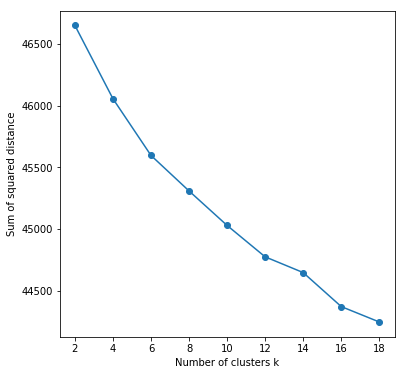

In [12]:
def evaluateClustering(kValue)
    sse = []
    for k in kValue:
        print(k)
        km = KMeans(n_clusters=k)
        km.fit(Features)
        sse.append(km.inertia_)

    # Plot sse against k
    plt.figure(figsize=(7, 7))
    plt.plot(list_k, sse, '-o')
    plt.xlabel('Number of clusters k')
    plt.ylabel('Sum of squared distance');
kvalueList[2,4,6,8,10,12,14,16,18]    
evaluateClustering(kvalueList)

# 3. Feature Selection & Extraction and classifying the document using deep nueral network

### Feature Extraction using Autoencoder 

Two main purpose of Feature selection is to reduce the vocabulary size to train the classifier more efficiently(specially with the classifiers which are expensive to train). The second one is improve the accuracy by avoiding the noise.

Here, My main purpose of feature selection is to train expensive classifiers effectively by reducing the number of the features. According to the first research papaer, I am using one of the mentioned method 'AutoEncoder' for feature extraction in text classifiction. 

Autoencoder can be used for dimensionality reduction and denoising the data. In this case, Autoencoder reduces the size of the vocabulary. Here I am using Deep autoencoder with few hidden layes as given below. The vocabulary size is reduced to 512 for each cluster. I also added regularization term to avoid overfitting. 

### Classification using SVM

For classification, SVM and MLP are used. For me, SVM model is working really well than MLP.

In [45]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

accruacyList = []
dict_of_companies = {k: v for k, v in dfWithClustersID.groupby('labels')}
for k in dict_of_companies:
    Features, target = preprocessing(dict_of_companies[k], 'Text', 'Bi:Topics')
    Features = Features.toarray()
    
    if(len(Features)>250):
        X_train, X_test, y_train, y_test = splitDataset(Features, target, 0.3, 10)
    
        encoding_dim = 512 

        input_img = Input(shape=(len(Features[0]),))

        encoded = Dense(encoding_dim, activation='relu',activity_regularizer=regularizers.l1(10e-5))(input_img)
        encoded = Dense(256, activation='relu',activity_regularizer=regularizers.l1(10e-5))(encoded)
        decoded = Dense(encoding_dim, activation='relu')(encoded)
        decoded = Dense(len(Features[0]), activation='sigmoid')(decoded)

            
        autoencoder = Model(input_img, decoded)
        encoder = Model(input_img, encoded)
        encoded_input = Input(shape=(encoding_dim,))
        decoder_layer = autoencoder.layers[-1]
        
        # decoder model
        decoder = Model(encoded_input, decoder_layer(encoded_input))
        autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
        autoencoder.fit(X_train, X_train, 
                    epochs=50,
                    batch_size=512,
                    shuffle=True,
                    validation_data=(X_test, X_test))
        encoded_texts = encoder.predict(Features)

        predicted, y_test = generateClassifier(encoded_texts, target, SVC)
        accuracyScoreSVC = evaluateModel(y_test, predicted)
        accruacyList.append(accuracyScoreSVC)
        print("The Accuracy for SVM model is {0:.2f}", accuracyScoreSVC)

Train on 1344 samples, validate on 577 samples
Epoch 1/50
1344/1344 [==============================] - 4s 3ms/step - loss: 1.4457 - val_loss: 1.1987
Epoch 2/50
1344/1344 [==============================] - 0s 50us/step - loss: 1.1488 - val_loss: 1.0256
Epoch 3/50
1344/1344 [==============================] - 0s 51us/step - loss: 0.9953 - val_loss: 0.9131
Epoch 4/50
1344/1344 [==============================] - 0s 51us/step - loss: 0.8913 - val_loss: 0.8317
Epoch 5/50
1344/1344 [==============================] - 0s 45us/step - loss: 0.8160 - val_loss: 0.7712
Epoch 6/50
1344/1344 [==============================] - 0s 50us/step - loss: 0.7592 - val_loss: 0.7243
Epoch 7/50
1344/1344 [==============================] - 0s 49us/step - loss: 0.7151 - val_loss: 0.6882
Epoch 8/50
1344/1344 [==============================] - 0s 52us/step - loss: 0.6811 - val_loss: 0.6596
Epoch 9/50
1344/1344 [==============================] - 0s 45us/step - loss: 0.6538 - val_loss: 0.6352
Epoch 10/50
1344/1344 [====

705/705 [==============================] - 0s 52us/step - loss: 1.0087 - val_loss: 0.8732
Epoch 5/50
705/705 [==============================] - 0s 68us/step - loss: 0.9454 - val_loss: 0.8351
Epoch 6/50
705/705 [==============================] - 0s 69us/step - loss: 0.8944 - val_loss: 0.8026
Epoch 7/50
705/705 [==============================] - 0s 69us/step - loss: 0.8513 - val_loss: 0.7744
Epoch 8/50
705/705 [==============================] - 0s 89us/step - loss: 0.8137 - val_loss: 0.7491
Epoch 9/50
705/705 [==============================] - 0s 69us/step - loss: 0.7806 - val_loss: 0.7260
Epoch 10/50
705/705 [==============================] - 0s 64us/step - loss: 0.7510 - val_loss: 0.7050
Epoch 11/50
705/705 [==============================] - 0s 58us/step - loss: 0.7244 - val_loss: 0.6860
Epoch 12/50
705/705 [==============================] - 0s 57us/step - loss: 0.7007 - val_loss: 0.6689
Epoch 13/50
705/705 [==============================] - 0s 58us/step - loss: 0.6801 - val_loss: 0.65

8226/8226 [==============================] - 0s 42us/step - loss: 0.2670 - val_loss: 0.2670
Epoch 34/50
8226/8226 [==============================] - 0s 41us/step - loss: 0.2669 - val_loss: 0.2670
Epoch 35/50
8226/8226 [==============================] - 0s 42us/step - loss: 0.2669 - val_loss: 0.2670
Epoch 36/50
8226/8226 [==============================] - 0s 40us/step - loss: 0.2669 - val_loss: 0.2670
Epoch 37/50
8226/8226 [==============================] - 0s 41us/step - loss: 0.2669 - val_loss: 0.2670
Epoch 38/50
8226/8226 [==============================] - 0s 41us/step - loss: 0.2669 - val_loss: 0.2670
Epoch 39/50
8226/8226 [==============================] - 0s 42us/step - loss: 0.2669 - val_loss: 0.2670
Epoch 40/50
8226/8226 [==============================] - 0s 41us/step - loss: 0.2669 - val_loss: 0.2670
Epoch 41/50
8226/8226 [==============================] - 0s 42us/step - loss: 0.2669 - val_loss: 0.2670
Epoch 42/50
8226/8226 [==============================] - 0s 41us/step - loss

515/515 [==============================] - 0s 66us/step - loss: 0.3110 - val_loss: 0.3052
Epoch 40/50
515/515 [==============================] - 0s 60us/step - loss: 0.3063 - val_loss: 0.3013
Epoch 41/50
515/515 [==============================] - 0s 66us/step - loss: 0.3024 - val_loss: 0.2979
Epoch 42/50
515/515 [==============================] - 0s 64us/step - loss: 0.2990 - val_loss: 0.2951
Epoch 43/50
515/515 [==============================] - 0s 62us/step - loss: 0.2961 - val_loss: 0.2925
Epoch 44/50
515/515 [==============================] - 0s 62us/step - loss: 0.2934 - val_loss: 0.2902
Epoch 45/50
515/515 [==============================] - 0s 60us/step - loss: 0.2911 - val_loss: 0.2883
Epoch 46/50
515/515 [==============================] - 0s 81us/step - loss: 0.2892 - val_loss: 0.2866
Epoch 47/50
515/515 [==============================] - 0s 127us/step - loss: 0.2875 - val_loss: 0.2851
Epoch 48/50
515/515 [==============================] - 0s 83us/step - loss: 0.2860 - val_loss

Epoch 18/50
516/516 [==============================] - 0s 70us/step - loss: 0.6440 - val_loss: 0.6021
Epoch 19/50
516/516 [==============================] - 0s 72us/step - loss: 0.6242 - val_loss: 0.5862
Epoch 20/50
516/516 [==============================] - 0s 69us/step - loss: 0.6047 - val_loss: 0.5697
Epoch 21/50
516/516 [==============================] - 0s 68us/step - loss: 0.5854 - val_loss: 0.5528
Epoch 22/50
516/516 [==============================] - 0s 66us/step - loss: 0.5661 - val_loss: 0.5353
Epoch 23/50
516/516 [==============================] - 0s 70us/step - loss: 0.5467 - val_loss: 0.5175
Epoch 24/50
516/516 [==============================] - 0s 66us/step - loss: 0.5272 - val_loss: 0.4994
Epoch 25/50
516/516 [==============================] - 0s 64us/step - loss: 0.5077 - val_loss: 0.4813
Epoch 26/50
516/516 [==============================] - 0s 68us/step - loss: 0.4884 - val_loss: 0.4634
Epoch 27/50
516/516 [==============================] - 0s 66us/step - loss: 0.4696

### Feature Extraction and classification using MLP

For me, MLP and SVM both work well. MLP is a powerful algorithm undoubtedly and it could give better results if we find the perfect hyperparameters. But as Nueral network is a blackbox algorithm, it is very hard to tune the hyperparameters perfectly. I have played with lots of hyperparameter to get the better result and this the best result i got so far.

In [26]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras import models, layers, optimizers, datasets, utils
dict_of_companies = {k: v for k, v in dfWithClustersID.groupby('labels')}
nnAccuracyList = []
for k in dict_of_companies:
    Features, target = preprocessing(dict_of_companies[k], 'Text', 'Bi:Topics')
    Features = Features.toarray()
    
    if(len(Features)>250):
        X_train, X_test, y_train, y_test = splitDataset(Features, target, 0.3, 10)
    
        encoding_dim = int(len(Features[0])/2) 

        input_img = Input(shape=(len(Features[0]),))

        encoded = Dense(encoding_dim, activation='relu',activity_regularizer=regularizers.l1(10e-5))(input_img)
        decoded = Dense(len(Features[0]), activation='sigmoid')(encoded)

        autoencoder = Model(input_img, decoded)
        encoder = Model(input_img, encoded)
        encoded_input = Input(shape=(encoding_dim,))
        decoder_layer = autoencoder.layers[-1]
        decoder = Model(encoded_input, decoder_layer(encoded_input))
        autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
        autoencoder.fit(X_train, X_train, 
                    epochs=50,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(X_test, X_test))
        encoded_texts = encoder.predict(Features)
        
        
        X_train, X_test, y_train, y_test = splitDataset(encoded_texts, target, 0.3, 25)
        y_train = utils.to_categorical(y_train, 103)
        y_test = utils.to_categorical(y_test, 103)
        input_dim = (len(encoded_texts[0]))
        print(input_dim)
        mlpInputs = layers.Input(shape=(input_dim,))
        n = layers.Dense(512, activation='relu')(mlpInputs)
        n = layers.Dense(512, activation='relu')(n)
        n = layers.Dense(256, activation='relu')(n)
        n = layers.Dense(128, activation='relu')(n)
        outcomes= layers.Dense(103, activation='softmax')(n)

        mlpModel = models.Model(inputs=mlpInputs, outputs=outcomes)

        mlpModel.compile(loss='categorical_crossentropy',
                      optimizer='Nadam', metrics=['accuracy'])

        history=mlpModel.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_test, y_test))
        valScore = mlpModel.evaluate(X_test, y_test)
        print('Test Loss Value:', valScore[0],'Test Accuracy Score:', valScore[1])
        nnAccuracyList.append(valScore[1])
       

Train on 1344 samples, validate on 577 samples
Epoch 1/50
1344/1344 [==============================] - 1s 1ms/step - loss: 0.7139 - val_loss: 0.7043
Epoch 2/50
1344/1344 [==============================] - 0s 14us/step - loss: 0.7018 - val_loss: 0.6944
Epoch 3/50
1344/1344 [==============================] - 0s 15us/step - loss: 0.6926 - val_loss: 0.6867
Epoch 4/50
1344/1344 [==============================] - 0s 14us/step - loss: 0.6852 - val_loss: 0.6800
Epoch 5/50
1344/1344 [==============================] - 0s 13us/step - loss: 0.6787 - val_loss: 0.6738
Epoch 6/50
1344/1344 [==============================] - 0s 14us/step - loss: 0.6725 - val_loss: 0.6677
Epoch 7/50
1344/1344 [==============================] - 0s 14us/step - loss: 0.6664 - val_loss: 0.6615
Epoch 8/50
1344/1344 [==============================] - 0s 16us/step - loss: 0.6602 - val_loss: 0.6551
Epoch 9/50
1344/1344 [==============================] - 0s 13us/step - loss: 0.6536 - val_loss: 0.6481
Epoch 10/50
1344/1344 [====

14416/14416 [==============================] - 0s 8us/step - loss: 0.2974 - val_loss: 0.2972
Epoch 28/50
14416/14416 [==============================] - 0s 8us/step - loss: 0.2967 - val_loss: 0.2965
Epoch 29/50
14416/14416 [==============================] - 0s 8us/step - loss: 0.2960 - val_loss: 0.2958
Epoch 30/50
14416/14416 [==============================] - 0s 7us/step - loss: 0.2954 - val_loss: 0.2952
Epoch 31/50
14416/14416 [==============================] - 0s 8us/step - loss: 0.2948 - val_loss: 0.2946
Epoch 32/50
14416/14416 [==============================] - 0s 8us/step - loss: 0.2942 - val_loss: 0.2940
Epoch 33/50
14416/14416 [==============================] - 0s 7us/step - loss: 0.2936 - val_loss: 0.2935
Epoch 34/50
14416/14416 [==============================] - 0s 8us/step - loss: 0.2931 - val_loss: 0.2929
Epoch 35/50
14416/14416 [==============================] - 0s 7us/step - loss: 0.2926 - val_loss: 0.2924
Epoch 36/50
14416/14416 [==============================] - 0s 8us/s

705/705 [==============================] - 0s 13us/step - loss: 0.3741 - val_loss: 0.3661
Epoch 42/50
705/705 [==============================] - 0s 13us/step - loss: 0.3692 - val_loss: 0.3616
Epoch 43/50
705/705 [==============================] - 0s 13us/step - loss: 0.3648 - val_loss: 0.3576
Epoch 44/50
705/705 [==============================] - 0s 14us/step - loss: 0.3610 - val_loss: 0.3541
Epoch 45/50
705/705 [==============================] - 0s 14us/step - loss: 0.3577 - val_loss: 0.3511
Epoch 46/50
705/705 [==============================] - 0s 13us/step - loss: 0.3548 - val_loss: 0.3485
Epoch 47/50
705/705 [==============================] - 0s 16us/step - loss: 0.3523 - val_loss: 0.3461
Epoch 48/50
705/705 [==============================] - 0s 13us/step - loss: 0.3500 - val_loss: 0.3440
Epoch 49/50
705/705 [==============================] - 0s 13us/step - loss: 0.3479 - val_loss: 0.3421
Epoch 50/50
705/705 [==============================] - 0s 14us/step - loss: 0.3461 - val_loss:

8226/8226 [==============================] - 1s 71us/step - loss: 2.2974 - acc: 0.4731 - val_loss: 2.3317 - val_acc: 0.4671
Epoch 5/10
8226/8226 [==============================] - 1s 71us/step - loss: 2.2836 - acc: 0.4731 - val_loss: 2.3560 - val_acc: 0.4671
Epoch 6/10
8226/8226 [==============================] - 1s 73us/step - loss: 2.2800 - acc: 0.4731 - val_loss: 2.3312 - val_acc: 0.4671
Epoch 7/10
8226/8226 [==============================] - 1s 70us/step - loss: 2.2787 - acc: 0.4731 - val_loss: 2.3261 - val_acc: 0.4671
Epoch 8/10
8226/8226 [==============================] - 1s 71us/step - loss: 2.2759 - acc: 0.4731 - val_loss: 2.3746 - val_acc: 0.4671
Epoch 9/10
8226/8226 [==============================] - 1s 71us/step - loss: 2.2833 - acc: 0.4731 - val_loss: 2.3994 - val_acc: 0.4671
Epoch 10/10
3526/3526 [==============================] - 0s 51us/step
Test Loss Value: 2.3476659075076514 Test Accuracy Score: 0.4671015314804311
Train on 4301 samples, validate on 1844 samples
Epoch 1

Epoch 19/50
515/515 [==============================] - 0s 14us/step - loss: 0.6496 - val_loss: 0.6398
Epoch 20/50
515/515 [==============================] - 0s 19us/step - loss: 0.6443 - val_loss: 0.6341
Epoch 21/50
515/515 [==============================] - 0s 14us/step - loss: 0.6388 - val_loss: 0.6281
Epoch 22/50
515/515 [==============================] - 0s 15us/step - loss: 0.6329 - val_loss: 0.6217
Epoch 23/50
515/515 [==============================] - 0s 16us/step - loss: 0.6267 - val_loss: 0.6150
Epoch 24/50
515/515 [==============================] - 0s 15us/step - loss: 0.6201 - val_loss: 0.6079
Epoch 25/50
515/515 [==============================] - 0s 15us/step - loss: 0.6132 - val_loss: 0.6004
Epoch 26/50
515/515 [==============================] - 0s 14us/step - loss: 0.6059 - val_loss: 0.5926
Epoch 27/50
515/515 [==============================] - 0s 17us/step - loss: 0.5982 - val_loss: 0.5843
Epoch 28/50
515/515 [==============================] - 0s 14us/step - loss: 0.5901

399/399 [==============================] - 0s 17us/step - loss: 0.6520 - val_loss: 0.6481
Epoch 35/50
399/399 [==============================] - 0s 17us/step - loss: 0.6504 - val_loss: 0.6465
Epoch 36/50
399/399 [==============================] - 0s 15us/step - loss: 0.6488 - val_loss: 0.6448
Epoch 37/50
399/399 [==============================] - 0s 18us/step - loss: 0.6471 - val_loss: 0.6431
Epoch 38/50
399/399 [==============================] - 0s 17us/step - loss: 0.6455 - val_loss: 0.6413
Epoch 39/50
399/399 [==============================] - 0s 23us/step - loss: 0.6438 - val_loss: 0.6395
Epoch 40/50
399/399 [==============================] - 0s 15us/step - loss: 0.6420 - val_loss: 0.6377
Epoch 41/50
399/399 [==============================] - 0s 18us/step - loss: 0.6403 - val_loss: 0.6358
Epoch 42/50
399/399 [==============================] - 0s 17us/step - loss: 0.6385 - val_loss: 0.6338
Epoch 43/50
399/399 [==============================] - 0s 17us/step - loss: 0.6366 - val_loss:

## Comparing the accuracy score before and after feature extraction and using different algorithms

After clustering and Before feature extraction the accuracy was more and after feature selection the accuracy got reduced for SVM. because the dimension of the data got recuced. Hence the accuracy will not have much difference before feature selection or after feature selection, but we will be able to run the classifier effectively which are expensive to train.

Very Large cluster and very small cluster does not have good accuracy after doing feature slection using autoencoder.

Reason: For small cluster, there is no enough data to train the model,hence giving low accuracy. For very large cluster,while reducing dimension, it may discard the important features or the data could be unbalanced too.

after doing clustering I got really good accuracy using SVM algorithm because each cluster has almost similar documents. Hence, Applying classifier to each cluster yields the more accuracy.
 
Clustering is semi-supervised learning, where first we identify the realtion between data(the falls under the same cluster). Meaning, even if the some of the data have different labels, it can fall under the same cluster. So that is unsupervised learning to get some knowledge about the relation in data. After that we apply lassification algorithm to clssify the data which is supervised approach.

This learning helps to improve the accuracy and feature selection helps to reduce the dimensionality of he given data. 


### References\n
[1] https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html <br/>
[2] https://blog.keras.io/building-autoencoders-in-keras.html <br/>
[3] https://www.scikit-yb.org/en/latest/api/cluster/elbow.html <br/>